### An Exploratory Analysis of Netflix’s Content Portfolio and Release Timing

In [1]:
#loading importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import os
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv(r"C:\Users\SKYBOOT\OneDrive\Desktop\Netflix_EDA\Data\netflix_titles.csv")

print(df.head())

  show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-13     80 min   
4   

In [2]:
print(df.columns)


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [3]:
print(df.dtypes)


show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB
None


In [5]:
df.shape ##checking how many rows and column we have

(7787, 12)

In [6]:
df.isnull().sum()  ##check the amound of row that contain null

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [7]:
#percentage of null values
df.isnull().sum()/(len(df))*100

show_id          0.000000
type             0.000000
title            0.000000
director        30.679337
cast             9.220496
country          6.510851
date_added       0.128419
release_year     0.000000
rating           0.089893
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64

In [8]:
missing=df.isnull().sum().sort_values(ascending=False)
print(missing)

director        2389
cast             718
country          507
date_added        10
rating             7
show_id            0
type               0
title              0
release_year       0
duration           0
listed_in          0
description        0
dtype: int64


In [9]:
##cleaning the data

df["date_added"]=pd.to_datetime(df["date_added"],errors="coerce")# Convert 'date_added' from text to real datetime
#Create 'year_added' from the date Netflix added the title
df["year_added"] = df["date_added"].dt.year

# Fill missing text fields with safe placeholders
# These placeholders prevent errors when we filter/plot
df_clean = df.dropna(subset=["year_added"]).copy()

# Convert year_added to integer (sometimes it becomes float)
df_clean["year_added"] = df_clean["year_added"].astype(int)

print("Rows before:", df.shape[0])
print("Rows after time-clean:", df_clean.shape[0])

print(df_clean[["date_added", "year_added"]].head())
df_clean.shape



Rows before: 7787
Rows after time-clean: 7689
  date_added  year_added
0 2020-08-14        2020
1 2016-12-23        2016
2 2018-12-20        2018
3 2017-11-16        2017
4 2020-01-01        2020


(7689, 13)

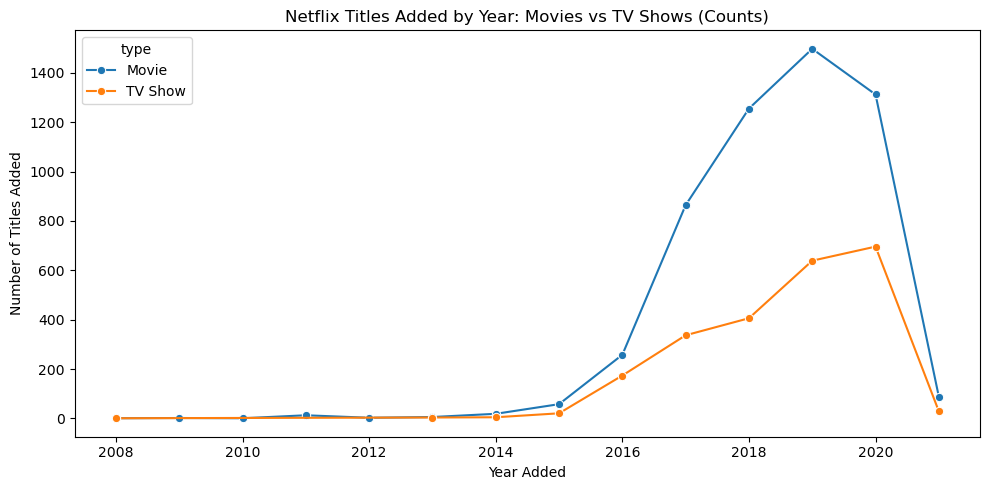

In [10]:
# MOVIES VS TV SHOWS: COUNTS BY YEAR

# Count how many titles were added each year for each type
year_counts = (
    df_clean.groupby(["year_added", "type"])
    .size()
    .reset_index(name="count")
)

# Plotting the year counts
plt.figure(figsize=(10, 5))
sns.lineplot(data=year_counts, x="year_added", y="count", hue="type", marker="o")
plt.title("Netflix Titles Added by Year: Movies vs TV Shows (Counts)")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles Added")
plt.tight_layout()
plt.show()


- Groups Netflix titles by `year_added` and `type` (Movie vs TV Show).
- Aggregates the number of titles added each year for each content type.
- Plots the time-series trend to compare portfolio mix over time.

### Key Insight
TV Shows account for a growing share of annual additions, while movie additions flatten in recent years.

### Why this matters
This indicates a strategic pivot toward serialized content, which is typically associated with higher retention and repeat engagement.

### Recommendation
Prioritize multi-season TV content in growth markets to support a retention-driven content strategy.

In [11]:
# Release Lag in Months
# Assumption: release date = Jan 1 of release_year (since exact release date isn't provided)
df_clean["release_year"] = pd.to_numeric(df_clean["release_year"], errors="coerce")

df_clean["assumed_release_date"] = pd.to_datetime(
    df_clean["release_year"].astype("Int64").astype(str) + "-01-01",
    errors="coerce"
)

df_clean["release_lag_days"] = (df_clean["date_added"] - df_clean["assumed_release_date"]).dt.days ##getting the lag
df_clean["release_lag_months"] = (df_clean["release_lag_days"] / 30.4375).round(1) 

df_lag = df_clean[(df_clean["release_lag_months"].notna()) & (df_clean["release_lag_months"] >= 0)].copy()

df_lag["release_lag_months"].describe()

count    7677.000000
mean       60.947336
std       104.870826
min         0.000000
25%         9.400000
50%        19.000000
75%        65.000000
max      1127.900000
Name: release_lag_months, dtype: float64

### What this code does
- Approximates release dates (Jan 1 of release year) to estimate the time between original release and Netflix addition.
- Converts the lag to months and removes invalid values.

### Key Insight
Release lag shows wide dispersion, indicating Netflix combines near-release acquisitions with older back-catalog licensing.

### Why this matters
Lag patterns proxy Netflix’s sourcing strategy (time-sensitive vs. catalog expansion).

### Recommendation
Accelerate near-release acquisitions in fast-moving genres; periodically review ROI on long-lag licensed content.

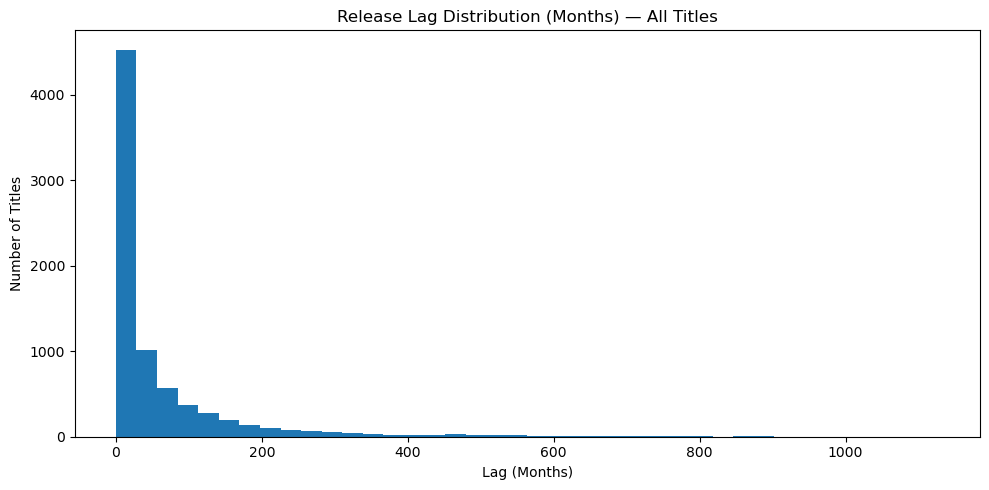

In [12]:
##plotting the release lag as an histogram for a better understanding
plt.figure(figsize=(10,5))
plt.hist(df_lag["release_lag_months"], bins=40)
plt.title("Release Lag Distribution (Months) — All Titles")
plt.xlabel("Lag (Months)")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.show()

### Key Takeaways
- The distribution is right-skewed, with a concentration of titles added long after release and a smaller cluster added closer to release.  
- This reflects a mixed sourcing strategy combining near-release acquisitions with back-catalog licensing to broaden the catalog.  
- Prioritize faster acquisition for time-sensitive genres and reassess the ROI of long-lag content in saturated categories.

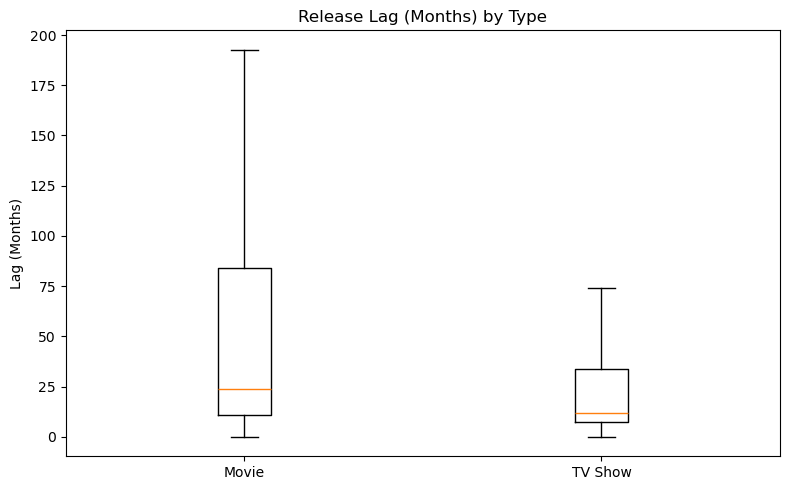

In [13]:
movies_lag = df_lag[df_lag["type"] == "Movie"]["release_lag_months"].dropna()
tv_lag = df_lag[df_lag["type"] == "TV Show"]["release_lag_months"].dropna()

data = []
labels = []
if len(movies_lag) > 0:
    data.append(movies_lag)
    labels.append("Movie")
if len(tv_lag) > 0:
    data.append(tv_lag)
    labels.append("TV Show")

plt.figure(figsize=(8,5))
plt.boxplot(data, labels=labels, showfliers=False)
plt.title("Release Lag (Months) by Type")
plt.ylabel("Lag (Months)")
plt.tight_layout()
plt.show()

### Key Takeaways
- TV shows are added to Netflix sooner after release than movies.  
- This means Netflix gets TV content faster to keep viewers engaged.  
- Movies are often added much later, using older content.  
- Netflix should get new TV shows faster and only add older movies that add real value.

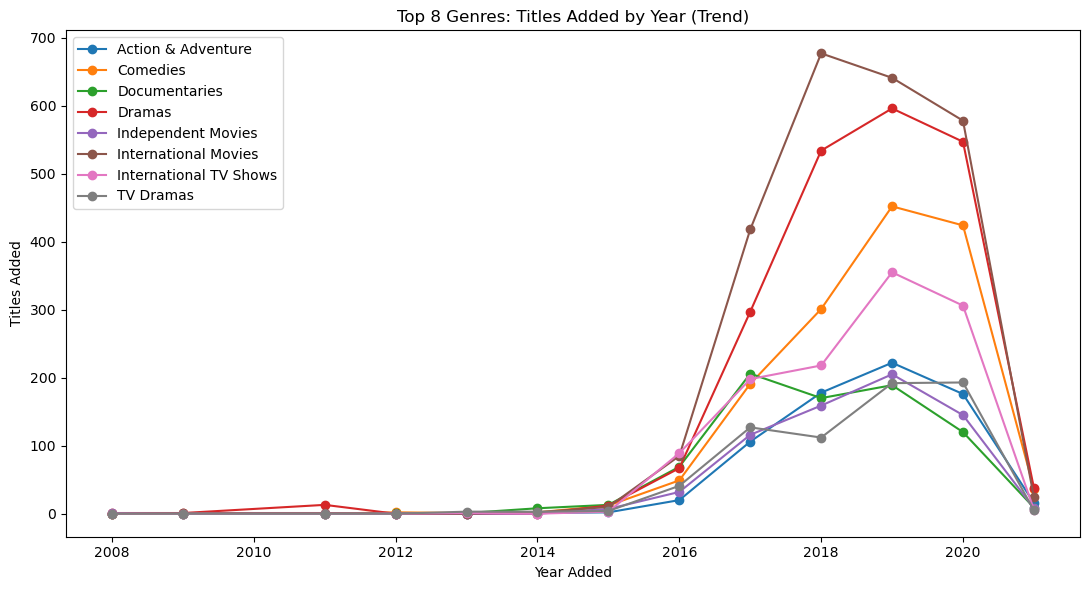

In [14]:
##getting the top 8 genere film 
df_genre = df_clean.copy()
df_genre["listed_in"] = df_genre["listed_in"].fillna("").astype(str)
df_genre["listed_in"] = df_genre["listed_in"].apply(lambda x: [g.strip() for g in x.split(",") if g.strip()])
df_genre = df_genre.explode("listed_in")
df_genre = df_genre[df_genre["listed_in"] != ""]

top_n = 8
top_genres = df_genre["listed_in"].value_counts().head(top_n).index.tolist()
df_top = df_genre[df_genre["listed_in"].isin(top_genres)].copy()

genre_trend = df_top.groupby(["year_added", "listed_in"]).size().reset_index(name="count")
pivot_genre = genre_trend.pivot(index="year_added", columns="listed_in", values="count").fillna(0).sort_index()

plt.figure(figsize=(11,6))
for g in pivot_genre.columns:
    plt.plot(pivot_genre.index, pivot_genre[g], marker="o", label=g)

plt.title(f"Top {top_n} Genres: Titles Added by Year (Trend)")
plt.xlabel("Year Added")
plt.ylabel("Titles Added")
plt.legend()
plt.tight_layout()
plt.show()

### Key Takeaways
- A small set of genres consistently dominates new additions, with growth concentrated in a few categories while others plateau.  
- Genre concentration increases portfolio risk and can limit audience diversification.  
- Maintain investment in high-performing core genres while selectively incubating emerging genres to diversify the content portfolio.

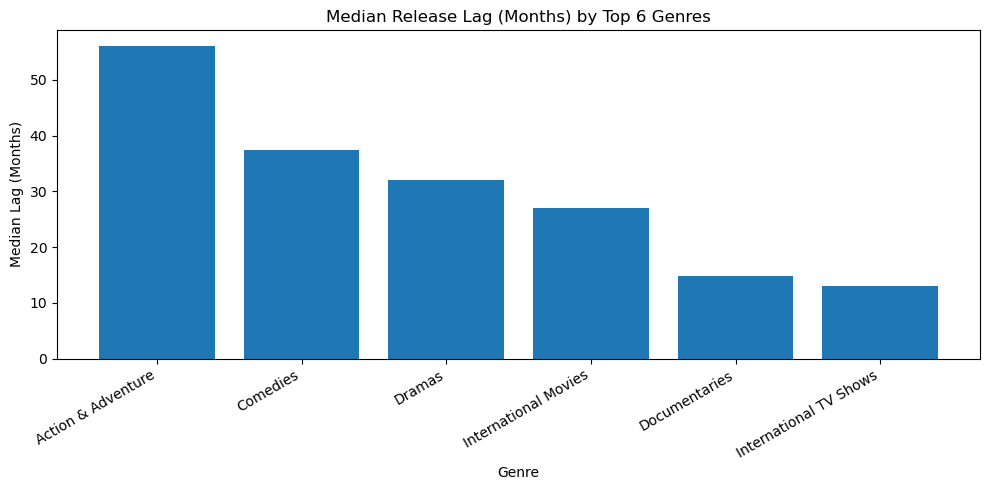

In [15]:
# Use df_lag but explode genres so each title contributes to its genres
df_lag_genre = df_lag.copy()
df_lag_genre["listed_in"] = df_lag_genre["listed_in"].fillna("").astype(str)
df_lag_genre["listed_in"] = df_lag_genre["listed_in"].apply(lambda x: [g.strip() for g in x.split(",") if g.strip()])
df_lag_genre = df_lag_genre.explode("listed_in")
df_lag_genre = df_lag_genre[df_lag_genre["listed_in"] != ""]

top_n_lag = 6
top_genres_lag = df_lag_genre["listed_in"].value_counts().head(top_n_lag).index.tolist()
df_lag_top = df_lag_genre[df_lag_genre["listed_in"].isin(top_genres_lag)].copy()

median_lag = df_lag_top.groupby("listed_in")["release_lag_months"].median().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(median_lag.index, median_lag.values)
plt.title(f"Median Release Lag (Months) by Top {top_n_lag} Genres")
plt.xlabel("Genre")
plt.ylabel("Median Lag (Months)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

### Key Takeaways
- Release lag varies materially by genre, indicating that some categories are acquired closer to release while others rely more heavily on back-catalog licensing.  
- Lag dispersion across genres reflects differentiated sourcing strategies driven by demand dynamics and content lifecycle.